## Deepseek v3.1 (Non-reasoning Model)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

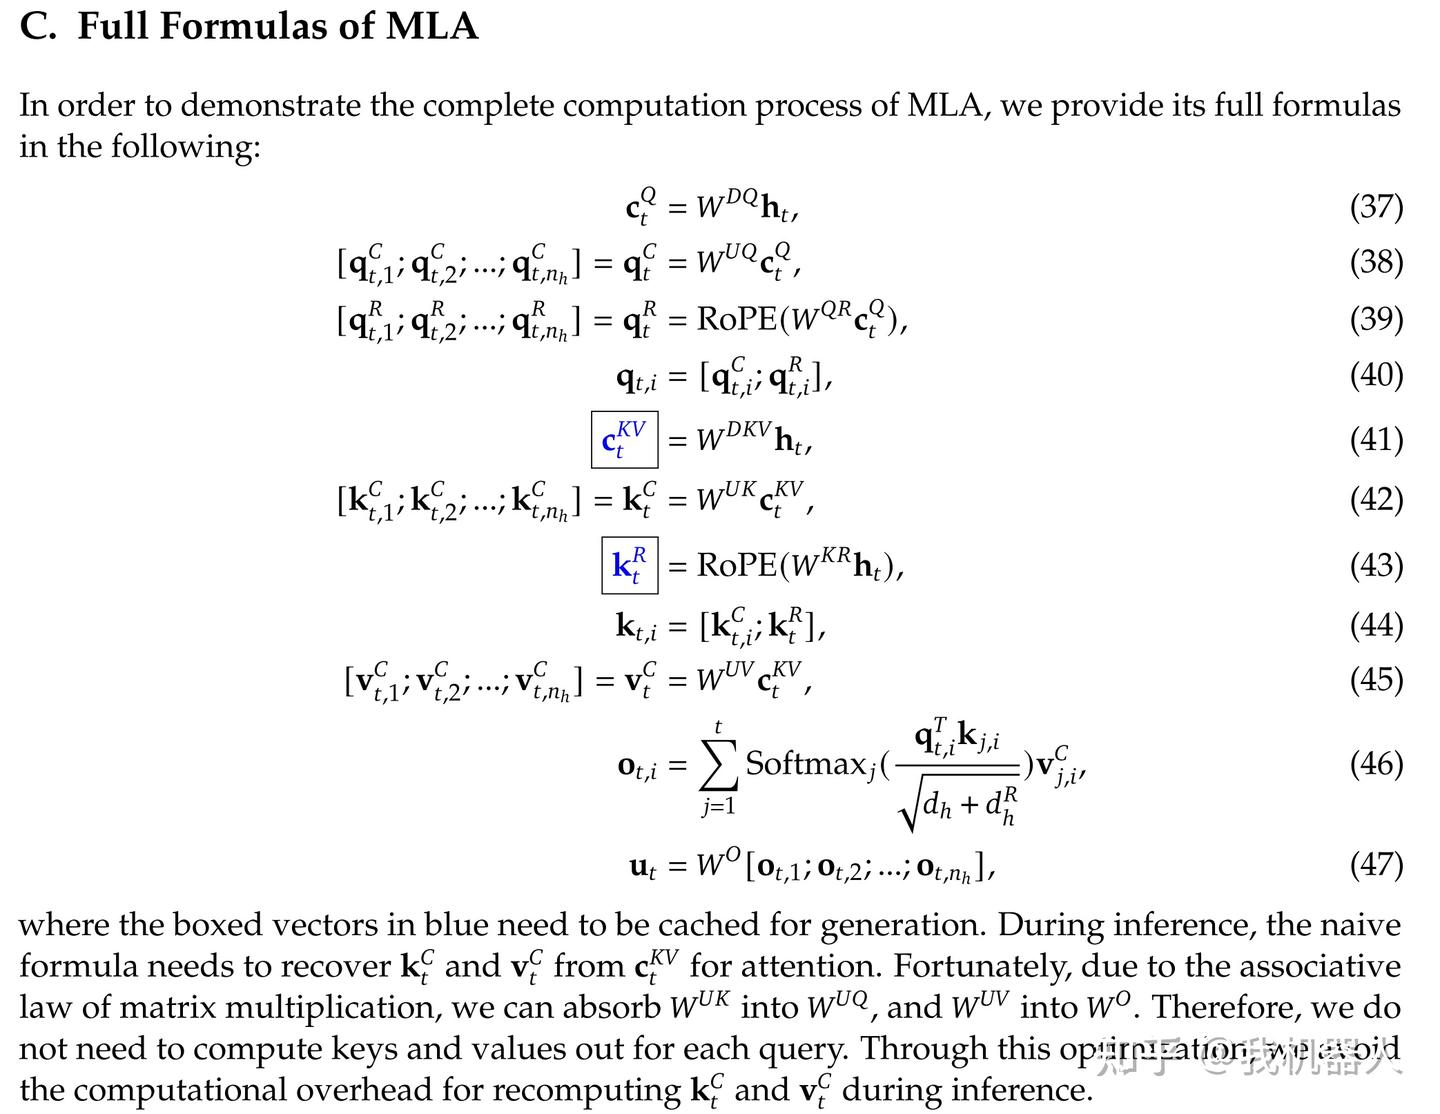

In [5]:
from IPython.display import Image

Image("Deepseek-MLA.jpg", width=800)

In [ ]:
@dataclass
class MLAConfig:
    n_embd: int = 768
    n_heads: int = 8
    kv_lora_rank: int = 0
    q_lora_rank: int = 0
    qk_nope_head_dim: int = 64
    qk_rope_head_dim: int = 64
    qk_head_dim: int = 768
    v_head_dim: int = 768


class MLA(nn.Module):
    """
    Multi-Head Attention Layer.

    Attributes:
        n_embd (int): Number of embedding dimensions.
        n_heads (int): Number of attention heads.
        kv_lora_rank (int): Rank of LoRA (Low-Rank Adaptation) projection
        q_lora_rank (int): Rank of LoRA projection for query vectors.
        qk_nope_head_dim (int): Dimensionality of non-positional query/key vectors.
        qk_rope_head_dim (int): Dimensionality of positional query/key vectors.
        qk_head_dim (int): Total Dimensionality of query/key vectors.
        v_head_dim (int): Dimensionality of value vectors.
        softmax_scale (float): Scaling factor for softmax function.

        
    """
    def __init__(self, config: MLAConfig):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_heads = config.n_heads
        self.kv_lora_rank = config.kv_lora_rank
        self.q_lora_rank = config.q_lora_rank
        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.qk_rope_head_dim = config.qk_rope_head_dim
        self.v_head_dim = config.v_head_dim
        self.softmax_scale = config.softmax_scale

        # If q_lora_rank is zero
        self.wq = nn.Linear(self.n_embd, self.n_heads * (self.qk_nope_head_dim + self.qk_rope_head_dim))

        # If q_lora_rank is non-zero
        self.wq_down = nn.Linear(self.n_embd, self.q_lora_rank)
        self.q_norm = RMSNorm(self.q_lora_rank)
        self.wq_up = nn.Linear(self.q_lora_rank, self.n_heads * (self.qk_nope_head_dim + self.qk_rope_head_dim))


        self.wkv_down = nn.Linear(self.n_embd, self.kv_lora_rank + self.qk_rope_head_dim)
        self.kv_norm = RMSNorm(self.kv_lora_rank)
        self.wkv_up = nn.Linear(self.kv_lora_rank, self.n_heads * (self.qk_nope_head_dim + self.v_head_dim))

        self.wo = nn.Linear(self.n_heads * self.v_head_dim, self.n_embd)
        self.softmax_scale = self.qk_head_dim ** -0.5

        if config.max_seq_len > config.original_seq_len:
            mscale = 0.1 * config.mscale * math.log(config.rope_scale) + 1.0
            self.softmax_scale *= mscale ** 2

        self.register_buffer("kv_cache", torch.zeros(config.max_batch_size, config.max_seq_len, self.kv_lora_rank), persistent=False)
        self.register_buffer("pe_cache", torch.zeros(config.max_batch_size, config.max_seq_len, self.qk_rope_head_dim), persistent=False)

    
    def forward(self, x, start_pos, freq_cis, mask):
        """
        Forward pass of the module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, n_embd).
            start_pos (int): Starting position for KV cache.
            freq_cis (torch.Tensor): Precomputed complex exponential values for rotary positional encoding.
            mask (torch.Tensor): Attention mask.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, n_embd).
        """

        B, T, C = x.size()

        end_pos = start_pos + T

        if self.q_lora_rank == 0:
            q = self.wq(x)
        else:
            q = self.wq_up(self.q_norm(self.wq_down(x)))
        
        q.view(B, T, self.n_heads, self.qk_nope_head_dim + self.qk_rope_head_dim)
        q_nope, q_pe = q.split([self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
        q_rope = apply_rotary_pos_emb(q_pe, freq_cis)
        
        kv_latent = self.wkv_down(x)
        kv_latent.view(B, T, self.n_heads, -1)
        kv_latent, kv_pe = kv_latent.split([self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
        kv_rope = apply_rotary_pos_emb(kv_pe, freq_cis)


        kv = self.wkv_up(self.kv_norm(kv_latent.view(B, T, -1)))
        kv = kv.view(B, T, self.n_heads, -1)

        kv_nope, v = kv.split([self.qk_nope_head_dim, self.v_head_dim], dim=-1)

        K = torch.cat([kv_nope, kv_rope], dim=-1)
        Q = torch.cat([q_nope, q_rope], dim=-1)

        self.kv_cache[:B, start_pos:end_pos] = self.kv_norm(kv_latent)
        self.pe_cache[:B, start_pos:end_pos] = kv_rope



## Bibliography

- [YT Video](https://www.youtube.com/watch?v=5avSMc79V-w)

The guy went insane-o style past the 2:15:00 mark. The explanations are vague and confusing. :/

Will revisit it later when I have more time to digest it.